In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import zipfile
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
receipt_df = pd.read_csv("../input/receipts-labels196/labels_receipts196.csv",header=None)
columns = ['class','xmin','ymin','w','h','image_id','ww','hh']
receipt_df.columns = columns
receipt_df.head()

,class,xmin,ymin,w,h,image_id,ww,hh
0,1,560,737,122,92,1000-receipt.jpg,750,1000
1,1,390,498,125,42,1001-receipt.jpg,645,1000
2,1,321,544,50,34,1002-receipt.jpg,750,1000
3,1,461,462,82,46,1003-receipt.jpg,750,1000
4,1,449,659,199,56,1004-receipt.jpg,750,1000


In [3]:
# path to zipped & working directories
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'

In [4]:
# path to zipped & working directories
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'

In [5]:
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [6]:
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))


In [7]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (300, 300))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (300, 300, 1))
    
    return img

In [8]:
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

In [9]:
train = train[:50]
train_cleaned = train_cleaned[:50]

In [10]:
receipts = []

#for f in sorted(os.listdir(path + 'train/')):
#    train.append(process_image(path + 'train/' + f))

In [11]:
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [12]:
def model():
    input_layer = Input(shape=(300, 300, 1))  
    # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 128)     73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 128)     147584

In [13]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=600, batch_size=8, verbose=1, callbacks=[callback])

Epoch 1/600
6/6 [==============================] - 15s 1s/step - loss: 0.2004 - mae: 0.3646 - val_loss: 0.2008 - val_mae: 0.4321
Epoch 2/600
6/6 [==============================] - 5s 777ms/step - loss: 0.1078 - mae: 0.2369 - val_loss: 0.1846 - val_mae: 0.4146
Epoch 3/600
6/6 [==============================] - 5s 772ms/step - loss: 0.0813 - mae: 0.2156 - val_loss: 0.1382 - val_mae: 0.3586
Epoch 4/600
6/6 [==============================] - 5s 777ms/step - loss: 0.0664 - mae: 0.1912 - val_loss: 0.1140 - val_mae: 0.3244
Epoch 5/600
6/6 [==============================] - 5s 773ms/step - loss: 0.0582 - mae: 0.1658 - val_loss: 0.0973 - val_mae: 0.2971
Epoch 6/600
6/6 [==============================] - 5s 773ms/step - loss: 0.0495 - mae: 0.1583 - val_loss: 0.0856 - val_mae: 0.2753
Epoch 7/600
6/6 [==============================] - 5s 773ms/step - loss: 0.0433 - mae: 0.1492 - val_loss: 0.0777 - val_mae: 0.2585
Epoch 8/600
6/6 [==============================] - 5s 772ms/step - loss: 0.0399 - mae

In [14]:
Y_test = model.predict(X_test, batch_size=16)

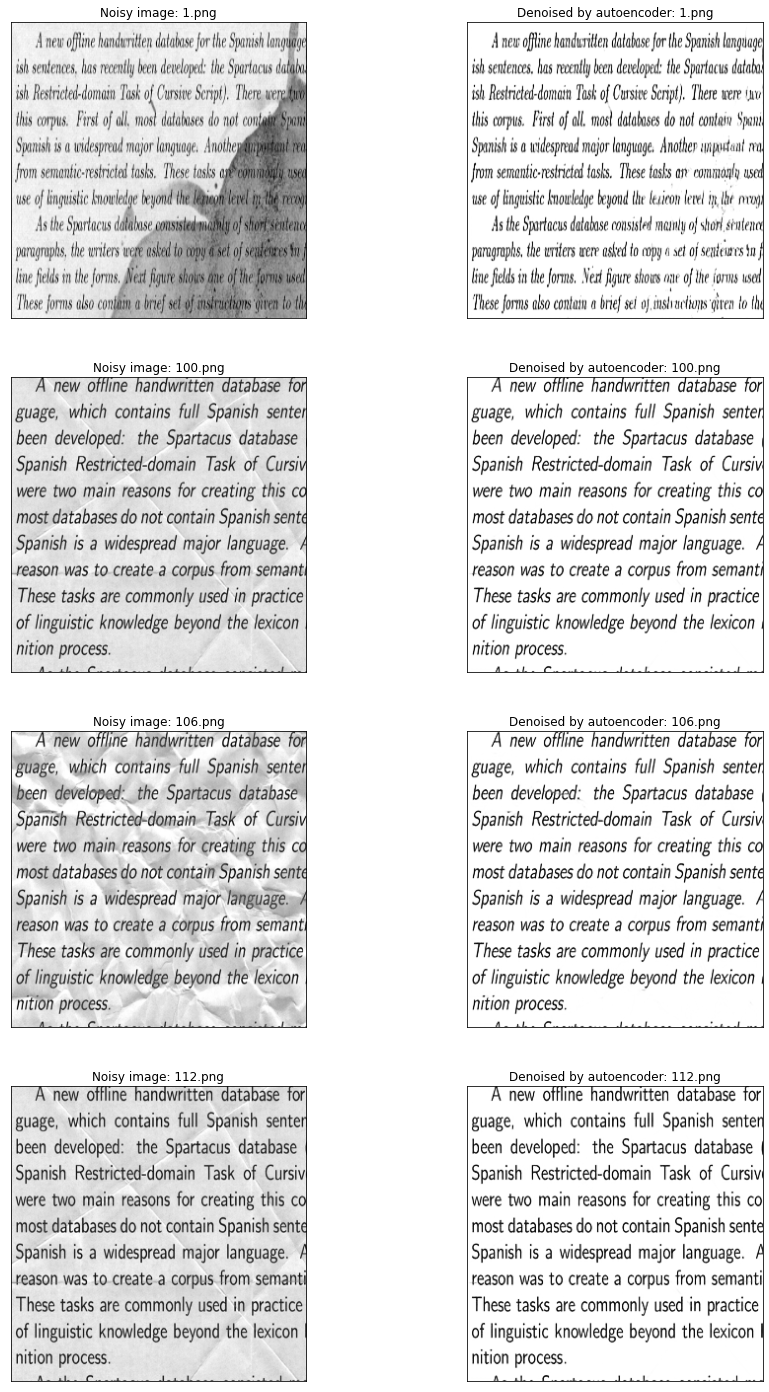

In [15]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [16]:
receipt_df = pd.read_csv("../input/receipts-labels/labels_receipts16.csv",header=None)
columns = ['class','xmin','ymin','w','h','image_id','ww','hh']
receipt_df.columns = columns

receipt_df1 = pd.read_csv("../input/receipts-labels196/labels_receipts196.csv",header=None)
columns = ['class','xmin','ymin','w','h','image_id','ww','hh']
receipt_df1.columns = columns
receipt_df1.head()

receipt_df = pd.concat([receipt_df,receipt_df1])

receipt_df.drop_duplicates(subset='image_id',keep="first",inplace=True)

In [17]:
receipts = []

#for f in sorted(os.listdir(path + 'train/')):
#    train.append(process_image(path + 'train/' + f))
image_ids = receipt_df['image_id'].unique()

for i in image_ids:
    file_name = f'../input/my-receipts1/my_receipts/{i}'
    receipts.append(process_image(file_name))
    
X_receipts = np.asarray(receipts)

In [18]:
receipts_test = model.predict(X_receipts,batch_size=16)

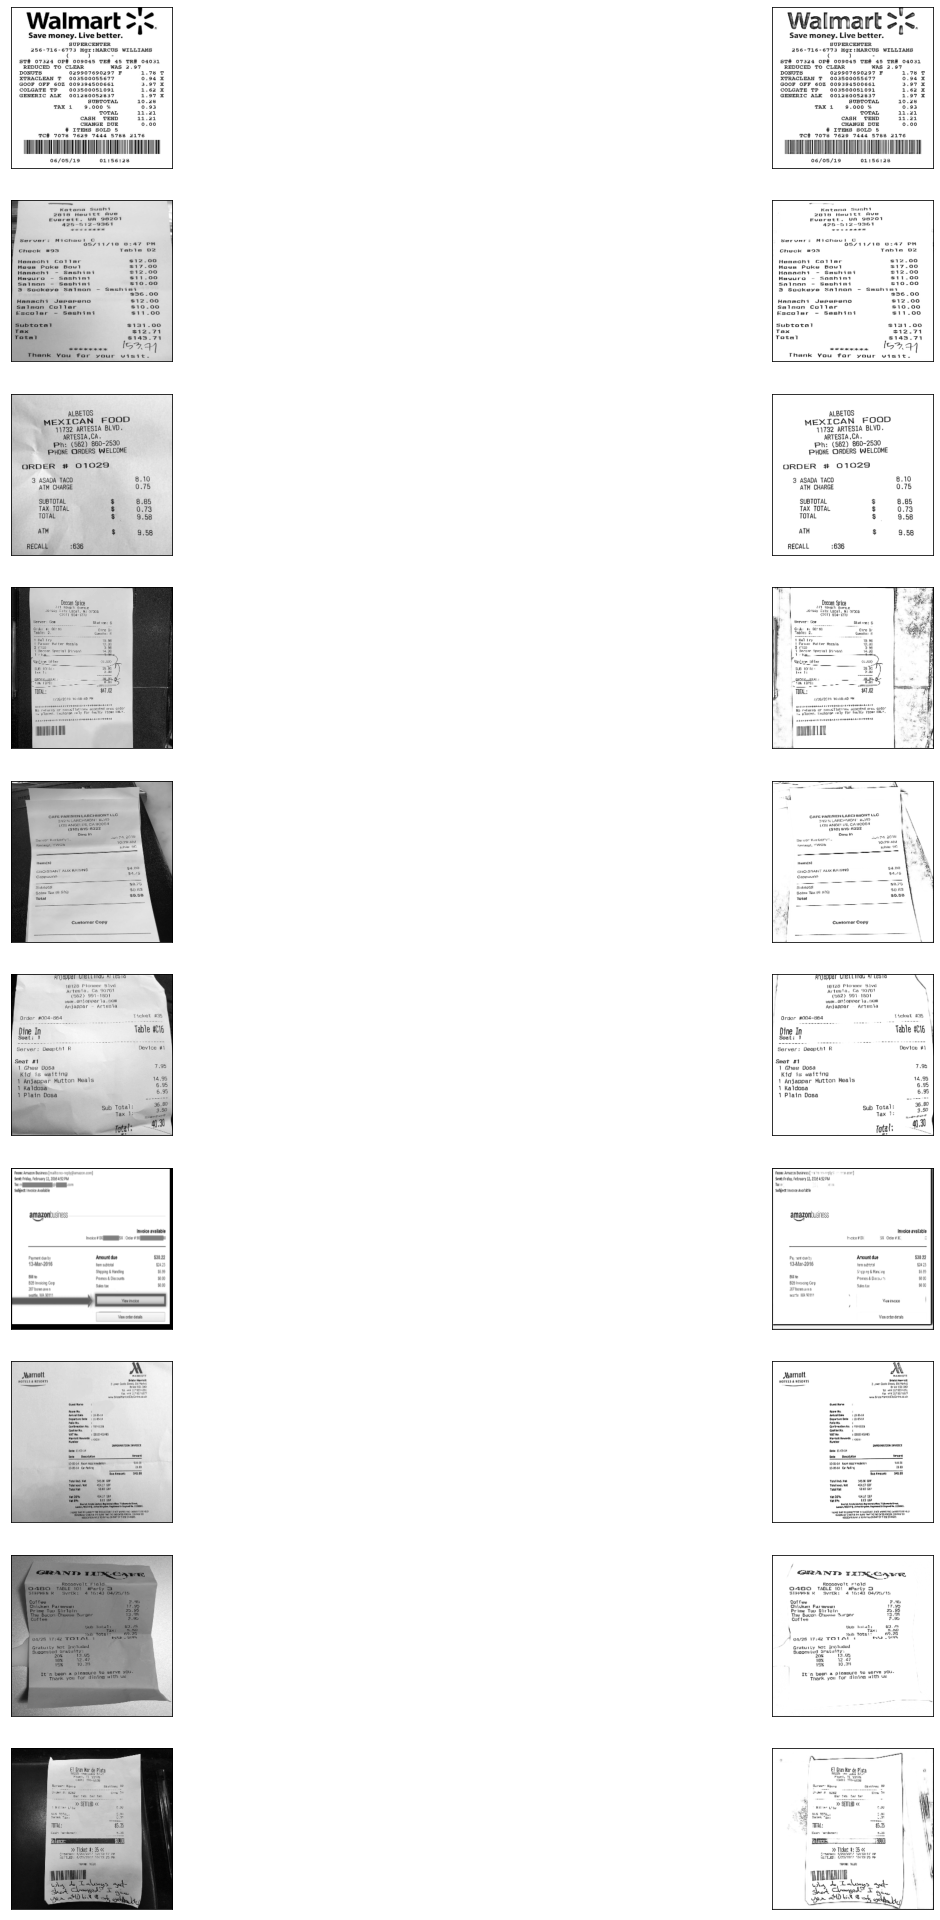

In [19]:
plt.figure(figsize=(25,35))
for i in range(0,20,2):
    plt.subplot(10,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(receipts[i][:,:,0], cmap='gray')
    #plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(10,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(receipts_test[i][:,:,0], cmap='gray')
    #plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [20]:
from numpy import savez_compressed
savez_compressed('receipts.npz', receipts_test)

In [21]:
#from numpy import savetxt
#savetxt('receipts.csv', receipts_test, delimiter=',')